# Tavi's troubleshooting

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


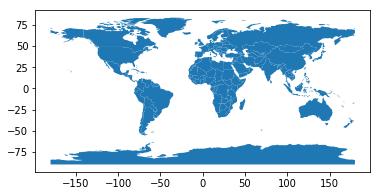

In [141]:
import fiona
import shapely
from shapely.geometry import shape
import geopandas as gpd
c = fiona.open(gpd.datasets.get_path('naturalearth_lowres'))
pol = c.next()
shape(pol['geometry'])
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot()
import matplotlib.pyplot as plt
plt.show()

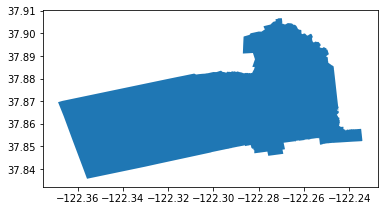

In [2]:
import osmnx as ox

city = ox.gdf_from_place('Berkeley, California')
city.plot()
plt.show()

In [3]:
import six
from six.moves import reload_module
reload_module(shapely)
reload_module(fiona)
reload_module(gpd)

<module 'geopandas' from '/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/geopandas/__init__.py'>

In [4]:
places = ox.gdf_from_places(['Botswana', 'Zambia', 'Zimbabwe'])
# ox.plot_shape(ox.project_gdf(places))
# places = ox.project_gdf(places)
# ox.save_gdf_shapefile(places)
# ox.plot_shape(ox.project_gdf(places))

In [5]:
places

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,29.375304,-17.778137,-26.905967,19.998647,"POLYGON ((19.9986474 -24.0971263, 19.999128 -2...",Botswana
1,33.702500,-8.271282,-18.076697,21.999351,"POLYGON ((21.9993509 -16.2063969, 22.0002166 -...",Zambia
2,33.068341,-15.609703,-22.424110,25.237300,"POLYGON ((25.2373 -17.9094116, 25.2373083 -17....",Zimbabwe


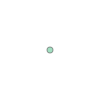

In [6]:
from shapely import geometry
coords = [-73.99, 40.70]
geometry.Point(coords) #call to Point works

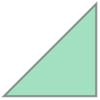

In [7]:
geometry.Polygon([(0, 0), (1, 1), (1, 0)]) #call to Polygon kills kernel

In [8]:
city = ox.graph_from_place('Manhattan, New York City, New York, USA', which_result=2)
city.plot()
plt.show()

AttributeError: 'MultiDiGraph' object has no attribute 'plot'

# Rob's code

In [156]:
import osmnx as ox, geopandas as gpd, networkx as nx
import pandas as pd, numpy as np
import matplotlib.cm as cm
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
rob, origin_point = ox.graph_from_address('42 Wolf Rd, Lebanon, New Hampshire', distance=5000, network_type='drive', return_coords=True)
center_node_rob = ox.get_nearest_node(rob, origin_point)
rob = ox.project_graph(rob)
# fig, ax = ox.plot_graph(rob)

In [4]:
tavi, origin_point = ox.graph_from_address('601 Minnesota Street, San Francisco, California', distance=4000, network_type='drive', return_coords=True)
center_node_tavi = ox.get_nearest_node(tavi, origin_point)
tavi = ox.project_graph(tavi)
# fig, ax = ox.plot_graph(tavi)

In [5]:
nyc, origin_point = ox.graph_from_address('2700 Broadway, New York, New York', distance=4000, network_type='bike', return_coords=True)
center_node_nyc = ox.get_nearest_node(nyc, origin_point)
nyc_map = ox.project_graph(nyc)

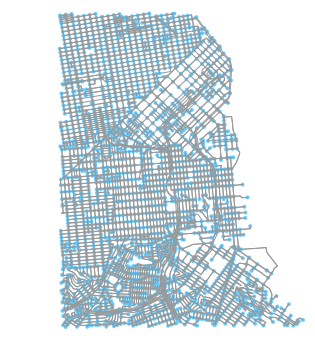

In [189]:
# RERUN FROM HERE to not hammer API
G = tavi.copy()
center_node = center_node_tavi
# gdf_nodes = ox.graph_to_gdfs(G0, edges=False)
# x, y = gdf_nodes['geometry'].unary_union.centroid.xy
# center_node = ox.get_nearest_node(G0, (y[0], x[0]))
# center_node
# G = ox.project_graph(G0).copy()
# G = G0.copy()
fig, ax = ox.plot_graph(G)

In [191]:
# default speeds from http://wiki.openstreetmap.org/wiki/OSM_tags_for_routing/Maxspeed

# 1 mph = 26.882 meters/minute
mph_to_minutes_per_meter = 26.882
node_penalty = 0.05 # minutes

def get_speed_meters_per_minute(edge_data):
    try:
        return float(data['maxspeed'].replace(' mph','')) * mph_to_minutes_per_meter
    except Exception as e:
        pass

    if edge_data['highway'] in ['motorway', 'trunk']:
        mph = 65
    elif edge_data['highway'] in ['motorway_link', 'trunk_link']:
        mph = 40
    elif edge_data['highway'] in ['primary_link']:
        mph = 25
    elif edge_data['highway'] in ['primary']:
        mph = 50
    elif edge_data['highway'] in ['secondary']:
        mph = 40
    elif edge_data['highway'] in ['tertiary']:
        mph = 30
    elif edge_data['highway'] in ['residential']:
        mph = 20
    elif edge_data['highway'] in ['service']:
        mph = 15
    elif 'link' in edge_data['highway']:
        mph = 20
    else:
        mph = 25
    return mph_to_minutes_per_meter

# add an edge attribute for time in minutes required to traverse each edge
# meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['mpm'] = get_speed_meters_per_minute(data)
    data['time'] = data['length'] / data['mpm'] + node_penalty # adding a node penalty (stop lights/signs)
    data['through_traffic'] = 1

for n, data in G.nodes(data=True):
    data['source_traffic'] = 1
    data['through_traffic'] = 0

### I had to change G.edge to G.edges because I'm running networkx 2.0 and I'm afraid to change it...

In [192]:
import requests

In [193]:
def osrm(origin_node, center_node, mode='driving'):
    start = '%f,%f' % (G.node[origin_node]['lon'],G.node[origin_node]['lat'])
    end = '%f,%f' % (G.node[center_node]['lon'],G.node[center_node]['lat'])
    query = 'http://router.project-osrm.org/route/v1/%s/%s;%s?annotations=nodes' % (mode,start,end)
    r = requests.get(query)

    return r.json()['routes'][0]['legs'][0]['annotation']['nodes']

# OSRM

In [198]:
# For every node in the map...
missing_edges = set([])
missing_nodes = set([])

for origin_node in tqdm(G.nodes()):
    try:
        route = nx.shortest_path(G, origin_node, center_node, weight='time')
        route = osrm(origin_node, center_node, mode='driving')
        route = [node for node in route if node in list(G)]
    except nx.NetworkXNoPath as e:
        continue

    # for that route, for every edge on the route, increment the through-traffic 
    #  count by the source traffic coming from the origin node..
    for i0, i1 in zip(route[:-1], route[1:]):
        try:
            G.edges[i0,i1,0]['through_traffic'] += G.node[origin_node]['source_traffic'] # new way
#         G.edge[i0][i1][0]['through_traffic'] += G.node[origin_node]['source_traffic'] # old way
        except KeyError:
            missing_edges.update((i0, i1))
            continue
            
    for node in route:
        try:
            data = G.nodes(data=True)[node]
            data['through_traffic'] += 1
        except KeyError:
            missing_nodes.update(node)
            continue

100%|██████████| 3599/3599 [35:10<00:00,  1.71it/s]


### Set edge colors and sizes

In [199]:
# edge_intensity = np.log10(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_intensity = np.log2(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_widths = (edge_intensity / edge_intensity.max() ) * 3 + 1
edge_intensity = (edge_intensity / edge_intensity.max() ) * .95 + .05
edge_intensity = (edge_intensity*255).astype(np.uint8)

### Set node colors and sizes

In [200]:
node_intensity = np.log2(np.array([data['through_traffic'] for n, data in G.nodes(data=True)]))
node_widths = (node_intensity / node_intensity.max() ) * 3 + 1
node_intensity = (node_intensity / node_intensity.max() ) * .95 + .05
node_intensity = (node_intensity*255).astype(np.uint8)

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


I kind of like the matplotlib perceptually uniform colormaps: https://matplotlib.org/users/plotting/colormaps/lightness_00.png

In [227]:
G_sorted.add_nodes_from(G.nodes(data=True))

In [228]:
G_sorted.nodes(data=True)[65290899]

{'highway': 'traffic_signals',
 'lat': 37.7642144,
 'lon': -122.3908315,
 'osmid': '65290899',
 'ref': nan,
 'source_traffic': 1,
 'through_traffic': 3584,
 'x': 553654.408681013,
 'y': 4179829.3233858426}

In [224]:
G.nodes(data=True)[65290899]

{'highway': 'traffic_signals',
 'lat': 37.7642144,
 'lon': -122.3908315,
 'osmid': '65290899',
 'ref': nan,
 'source_traffic': 1,
 'through_traffic': 3584,
 'x': 553654.408681013,
 'y': 4179829.3233858426}

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


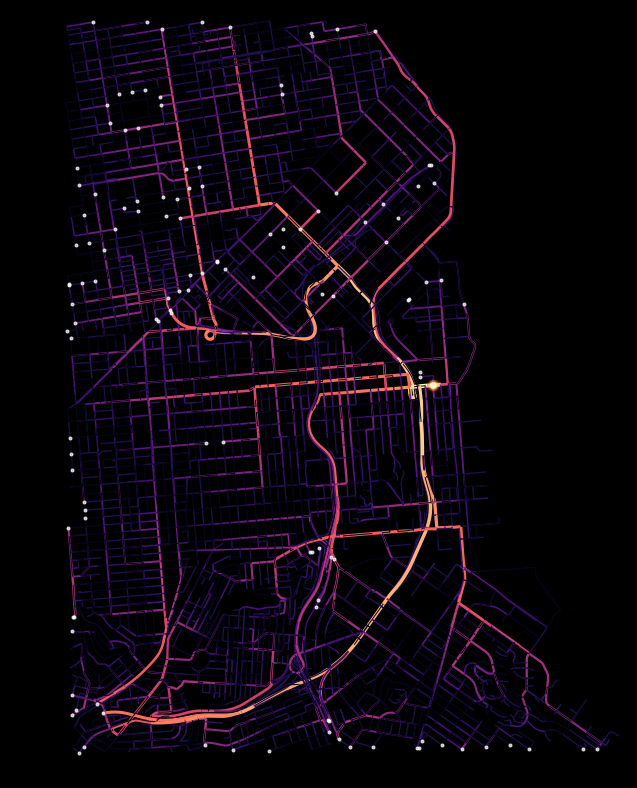

In [244]:
cmap = cm.get_cmap(name='magma')
edge_colors = cmap(edge_intensity)
node_colors = cmap(node_intensity)

# Sort to fix edge hierarchy:
edgelist = sorted(G.edges(data=True), key=lambda x: x[2]['through_traffic'], reverse=True)

# Neither of these work
# G_sorted = nx.MultiDiGraph(edgelist)
# G_sorted.add_nodes_from(G.nodes(data=True))
# G_sorted.graph = G.graph

# G_sorted = G.copy()
# G_sorted.remove_edges_from(G.edges())
# G_sorted.add_edges_from(edgelist)


fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0, save=True,
                       fig_height=14, fig_width=16, use_geom=True , close=False, show=False,  bgcolor='k')
# fig, ax = ox.plot_graph(G_sorted, node_color=node_colors, node_size=10, equal_aspect=True, edge_linewidth=0, save=True,
#                         fig_height=14, fig_width=25, use_geom=True , close=False, show=False,  bgcolor='k')
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='red', s=150, zorder=10, alpha=.25)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='pink', s=100, zorder=10, alpha=.3)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='yellow', s=50, zorder=10, alpha=.6)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='white', s=30, zorder=10, alpha=.75)

for node in missing_edges:
    ax.scatter([G.node[node]['x']], [G.node[node]['y']],
           color='white', s=9, zorder=10, alpha=.75)

fig.show()

# OSMNX:

In [138]:
# For every node in the map...
for origin_node in tqdm(G.nodes()):
    try:
        route = nx.shortest_path(G, origin_node, center_node, weight='time')
#         route = osrm(origin_node, center_node)
#         route = [node for node in route if node in list(G)]
    except nx.NetworkXNoPath as e:
        continue

    # for that route, for every edge on the route, increment the through-traffic 
    #  count by the source traffic coming from the origin node..
    for i0, i1 in zip(route[:-1], route[1:]):
        try:
            G.edges[i0,i1,0]['through_traffic'] += G.node[origin_node]['source_traffic'] # new way
#         G.edge[i0][i1][0]['through_traffic'] += G.node[origin_node]['source_traffic'] # old way
        except KeyError:
            print(i0, i1)
            continue

100%|██████████| 3599/3599 [01:24<00:00, 42.72it/s]


In [139]:
# idx = np.log10(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
idx = np.log2(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_widths = (idx / idx.max() ) * 3 + 1
idx = (idx / idx.max() ) * .95 + .05
idx = (idx*255).astype(np.uint8)

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


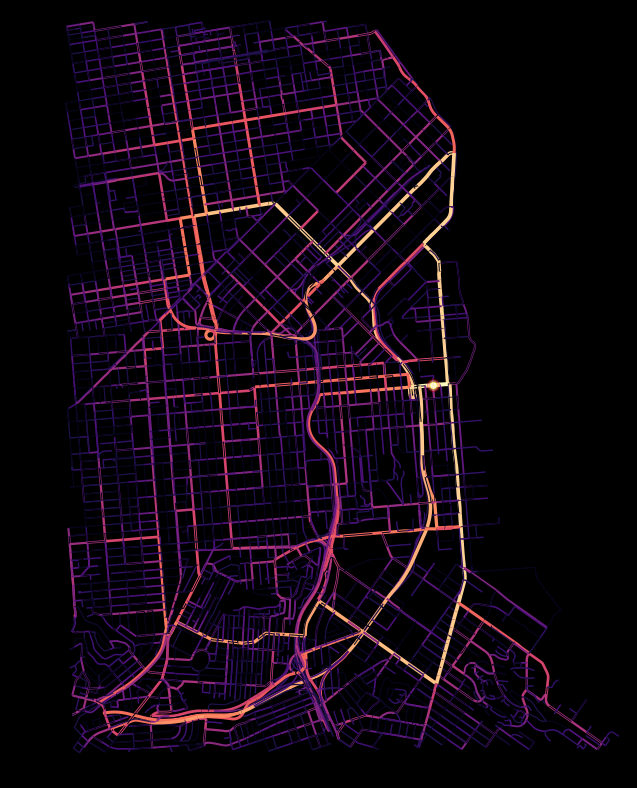

In [140]:
cmap = cm.get_cmap(name='magma')
edge_colors = cmap(idx)

fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0, save=True,
                       fig_height=14, fig_width=16, use_geom=True , close=False, show=False,  bgcolor='k')
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='red', s=150, zorder=10, alpha=.25)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='pink', s=100, zorder=10, alpha=.3)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='yellow', s=50, zorder=10, alpha=.6)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='white', s=30, zorder=10, alpha=.75)
fig.show()

In [285]:
# fn = 'map.html'
# folium_map = ox.plot_graph_folium(G3, #edge_color=edge_colors.tolist(), 
#                               edge_width=2,#edge_widths.tolist(), 
# #                                  equal_aspect=True, node_size=0,
#  #                      fig_height=14, fig_width=16, use_geom=True
#                          )

In [286]:
# from IPython.display import IFrame
# folium_map.save(fn)
# IFrame(fn, width=600, height=500)

# Things to try
- spatially uniform colormaps: such as inferno. done.
- logarithmic axes
    - switch to polar coordinates
- the map seems wrong, takes long detours? added "node penalty"
- map of PageRank?
- thin roads get drawn on top of fat roads